### Wine Quality Prediction

In this notebook, we will train machine learning (regression) models to predict the quality of wine based on several features. 

We will use the transformed Wine Quality dataset, which includes the following predictive features: 

**fixed acidity**, **volatile acidity**, **citric acid**, **pH**, **sulphates**, **alcohol**, **wine_type**, **residual_sugar_density_mean**, **chlorides_density_ratio**, **sulfur_dioxide_mean**. 

The target attribute is **quality**.

We will train models using five different algorithms from sklearn: 

**LinearRegression**, **Ridge**, **Lasso**, **DecisionTreeRegressor**, **RandomForestRegressor**. 

For each algorithm, we will tune two to three hyperparameters.

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

# Ignore ConvergenceWarning and DataConversionWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Data source & destination path
in_data = '../data/'

In [2]:
## Load and Prepare Datasets
train_df = pd.read_csv(f'{in_data}train_transformed.csv')
val_df = pd.read_csv(f'{in_data}validate_transformed.csv')
test_df = pd.read_csv(f'{in_data}test_transformed.csv')

y_train=train_df['quality'].to_frame()
X_train=train_df[train_df.columns.difference(['quality'])]
y_val=val_df['quality'].to_frame()
X_val=val_df[val_df.columns.difference(['quality'])]
y_test=test_df['quality'].to_frame()
X_test=test_df[test_df.columns.difference(['quality'])]

In [3]:
## Define the models and their hyperparameters for tuning
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'fit_intercept': [True, False],
            'solver': ['svd', 'sag']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'fit_intercept': [True, False],
            'warm_start': [True, False]
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [1, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'max_depth': [1, 5, 10],
            'n_estimators': [10, 50, 100],
            'min_samples_split': [2, 5, 10]
        }
    }
}

In [4]:
## Encode Categorical Features
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
encoder = OneHotEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_train)
X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)

In [5]:
## Train the models and tune the hyperparameters using GridSearchCV
best_models = {}
for model_name in models:
    clf = GridSearchCV(models[model_name]['model'], models[model_name]['params'], cv=5)
    clf.fit(X_train, y_train)
    best_models[model_name] = clf.best_estimator_

In [6]:
## Predict the validation set using each model
predictions = {}
for model_name in best_models:
    predictions[model_name] = best_models[model_name].predict(X_val)

In [7]:
## Evaluate the predictions using RMSE
rmses = {}
for model_name in predictions:
    rmses[model_name] = np.sqrt(mean_squared_error(y_val, predictions[model_name]))

In [8]:
## Identify the best model based on RMSE
best_model_name = min(rmses, key=rmses.get)
best_model = best_models[best_model_name]
print(f'Best model is {best_model_name}')
rmse_val = rmses[best_model_name]
print(f"RMSE on the validation set is: {rmse_val}")

Best model is RandomForestRegressor
RMSE on the validation set is: 0.7001605262951086


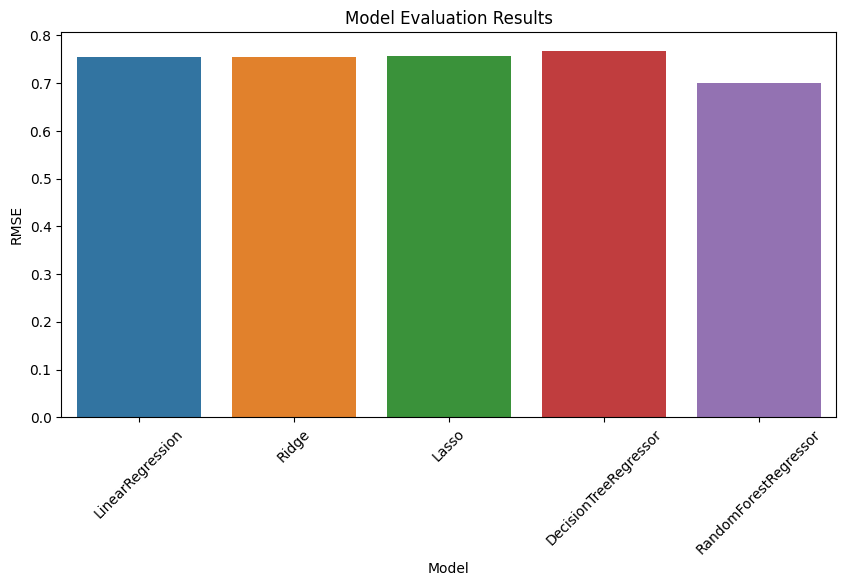

In [9]:
## Visualize the evaluation results using a bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(rmses.keys()), y=list(rmses.values()))
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Evaluation Results')
plt.xticks(rotation=45)
plt.show()

In [10]:
## Persist the best model alongside the encoder for deployment
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(encoder, '../models/encoder.pkl')

['../models/encoder.pkl']

In [11]:
## Load the saved (model, encoder) and apply them on the test data for testing
best_model = joblib.load('../models/best_model.pkl')
encoder = joblib.load('../models/encoder.pkl')
X_test = encoder.transform(X_test)
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on the test set is: {rmse_test}")

RMSE on the test set is: 0.6840565922835725
